<a href="https://colab.research.google.com/github/svrbasky/Age_Prediction_using_DL/blob/main/Age_Predictor_using_Deep_Learning_on_Blood_Test_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/NivedhaBalakrishnan/AgingClock


Cloning into 'AgingClock'...
remote: Enumerating objects: 389, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 389 (delta 8), reused 5 (delta 5), pack-reused 364
Receiving objects: 100% (389/389), 40.66 MiB | 11.69 MiB/s, done.
Resolving deltas: 100% (146/146), done.
Updating files: 100% (136/136), done.


In [ ]:
%cd AgingClock

/content/AgingClock


In [ ]:
import math
import torch
from torch import nn
from pathlib import Path
import pandas as pd
import ipywidgets as widgets
from ipywidgets import GridspecLayout,Dropdown,BoundedFloatText,Button,Layout
import ageclock
from ageclock import NN

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
DEBUG = False

In [ ]:
def example_change(change):
    def change_values(age):
        sex_box.index = None
        sex_box.value = 'Male' if samples[age][0] == 1 else 'Female'
        for i in range(len(samples[age])):
            grid[i+2, 2].value = samples[age][i+1]

    if change['type'] == 'change' and change['name'] == 'value':
        if change['new'] == '-':
            sex_box.index = None
            sex_box.value = '-'
            for i in range(len(list(samples.values())[0])):
                grid[i+2, 2].value = 0
        elif float(change['new'].split()[1]) in list(samples.keys()):
            change_values(int(change['new'].split()[1]))

In [ ]:
def create_button(description, button_style, height='auto'):
    button = Button(description=description,
                  tooltip=description,
                  button_style=button_style,
                  disabled=True,
                  layout=Layout(height=height, width='auto'))
    button.style.font_weight = 'bold'
    return button

In [ ]:
def submit_clicked(b):
    def predict(inputs):
        path = Path('models/adm_state_dict')
        lm = NN()
        lm.load_state_dict(torch.load(path))
        lm.eval()
        inputs = torch.Tensor(inputs)
        return(lm(inputs)-27)

    age_button.button_style='primary'
    markers = [grid[i+2, 2].value for i in range(len(biomarkers))]
    if sex_box.value=='-':
        age_button.description='Please enter your Sex'
        age_button.style.button_color = 'orange'
    elif 0 in markers:
        age_button.description='Please enter missing biomarkers'
        age_button.style.button_color = 'orange'
    else:
        markers.insert(0, int(sex_box.value=='Male'))
        age_button.style.button_color = '#2471a3'
        if DEBUG: age_button.tooltip = str(markers)
        age_button.description='Your biological age is {} '.format(
            round(predict(markers).data.item()))

In [ ]:
warn_text='''Age predictor needs all blood marker values and your Sex to make
a prediction. If you are missing values and filling them in, this might have
a dramatic impact on the results. However your entered Height, Weight, and
Smoking Status are not required for estimating your biological age and only
used for record keeping.'''
title_text = ['Deep Biomarkers Of Human Aging: How Old By a Basic Blood Test',
         '''This is a deep-learned predictor of your age made with a DNN
         trained on tens of thousands anonymized human blood tests. <br>
         Enter your data below and the model will guess your age.''']
asterics_text = [
    '* This should be in your clinical biochemistry blood test results.',
    '''** Required parameter for minimal prediction accuracy of 70% within
    10 year frame.''',
    '''*** We can not show you reference values before knowing your age
    apriori, so this is only a reference metric.''']

In [ ]:
biomarkers=pd.read_csv('data/non_NHANES/markers_units.csv').values.tolist()

samples = [list(pd.read_csv('data/non_NHANES/samples_from_aging.csv').iloc[i])
           for i in range(len(pd.read_csv(
               'data/non_NHANES/samples_from_aging.csv')))]
samples = {sample[-1]:sample[:-1] for sample in samples}

In [ ]:
header_grid = widgets.GridspecLayout(4, 5, width='auto')

title_html = widgets.HTML(
    value='''<center><h1 style="font-family:verdana"><font color=
    "paleturquoise">{}</h1><hr><h2 style="font-family:verdana">
    {}</h2></center>'''.format(*title_text))

height_box = widgets.Text(
    placeholder='Enter your height (Optional)',
    description='Height:')

weight_box = widgets.Text(
    placeholder='Enter your weight (Optional)',
    description='Weight:')

load_html = widgets.HTML(value = '<center><h3>Load an Example</h3></center>',
                          layout=Layout(top='45px', left='5px'))

sex_box = widgets.Dropdown(options=['-','Male','Female'], description='Sex:')

smoke_box = widgets.Dropdown(options=['-','No','Yes'], description='Smoke:')

load_box = widgets.Dropdown(
    value='-',
    options=['-']+['Male '+str(int(x))+' y/o' for x in list(samples.keys())],
    description=' ',
    layout=Layout(bottom='45px', right='5px'))
load_box.observe(example_change)

header_grid[0:1,1:-1] = title_html
header_grid[2,1] = height_box
header_grid[2,2] = weight_box
header_grid[2,3] = load_html
header_grid[3,1] = sex_box
header_grid[3,2] = smoke_box
header_grid[3,3] = load_box

header_grid

GridspecLayout(children=(HTML(value='<center><h1 style="font-family:verdana"><font color=\n    "paleturquoise"…

In [ ]:
grid=widgets.GridspecLayout(len(biomarkers)+3,5,height='950px',width='auto')
HEIGHT = '28px'

grid[0,1:-1] = widgets.HTML(
    value='<center><h4><font color="orange">{}</h4></center>'.format(
        warn_text))

grid[1,1] = create_button('Blood Marker*', 'primary', '50px')
grid[1,2] = create_button('Your Value', 'primary', '50px')
grid[1,3] = create_button('Units and Sample Metric***', 'primary', '50px')

for i, marker in enumerate(biomarkers):
        grid[i+2,1] = create_button(marker[0], 'info', HEIGHT)
        grid[i+2,3] = create_button(marker[1], 'info', HEIGHT)
        grid[i+2,2] = BoundedFloatText(min=0,
                                        max=1000,
                                        layout=Layout(height='auto',
                                                      width='auto'),
                                        value=None,
                                        step=0.01,
                                        disabled=False)

grid[-1,1:] = widgets.HTML(
    value = '''<p><font color="orange">{}</p><p><fontcolor=
    "orange">{}</p><p><font color="orange">{}
    </h4>'''.format(*asterics_text))

grid

GridspecLayout(children=(HTML(value='<center><h4><font color="orange">Age predictor needs all blood marker val…

In [ ]:
footer_grid = widgets.GridspecLayout(3,5)

submit_button = Button(description='Submit',
                tooltip='Predict your age with entered biomarkers',
                button_style='primary',
                layout=Layout(height='50px', width='auto', bottom='0px'))
age_button = Button(layout=Layout(height='50px', width='auto', top='15px'))
age_button.style.button_color = '#111111'
age_button.style.font_weight = 'bold'
submit_button.style.font_weight = 'bold'
submit_button.on_click(submit_clicked)
footer_grid[0,2] = submit_button
footer_grid[1,2] = age_button

footer_grid

GridspecLayout(children=(Button(button_style='primary', description='Submit', layout=Layout(bottom='0px', grid…

In [ ]:
footer_html = {
    'gap':'<br><br><br><br><br><br><hr>',

    'sjsu':'''Made by Dmytro Mishchenko as a project for the
    <a href='https://pytorch2021.devpost.com/'><u>PyTorch Hackathon
    </u></a> with the help of a <a href='https://mlatsjsu.club'>
    <u>Machine Learning Club</u></a> at San Jose State University.''',

    'github':'''This project is open-source and is covered by the MIT License,
    for more details or if you want to contribure here is the
    <a href='https://github.com/mdmittriy/AgingClock'><u>
    GitHub repository</u></a>.''',

    'demo':'''You can take a look at the demo of this project <a
    href='https://www.youtube.com/watch?v=SCxRiXIG13Q'><u>here</u></a>. And
    notice that this work is heavily inspired by
    <a href='http://www.aging.ai'><u>aging.ai</u></a>'''}

widgets.HTML(value='<center>{}<br>{}<br>{}<br>{}</center>'.format(
    footer_html['gap'],footer_html['sjsu'],
    footer_html['github'],footer_html['demo']))

HTML(value="<center><br><br><br><br><br><br><hr><br>Made by Dmytro Mishchenko as a project for the\n    <a hre…

In [ ]:
!pip install fastbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 53.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 57.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pathlib import Path

import fastbook
from fastbook import *
from fastai.tabular.all import *

In [ ]:

DATA_PATH = Path.cwd()/'data'
train_df = pd.read_csv(DATA_PATH/'train_data.csv')
test_df = pd.read_csv(DATA_PATH/'test_data.csv')
df = pd.read_csv(DATA_PATH/'full_data.csv')

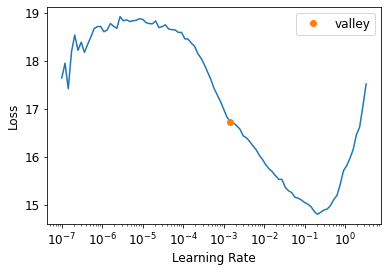

In [ ]:
train_idx = np.array(range(len(train_df))).tolist()
test_idx = np.array(range(len(test_df)))
test_idx = (test_idx + train_idx[-1] + 1).tolist()
cont = list(df.columns)[1:-1]
cat = list(df.columns)[0:1]
dep_var = list(df.columns)[-1]
procs = [Categorify]
dls = TabularDataLoaders.from_df(df, DATA_PATH, procs=procs, cat_names=cat, cont_names=cont,
                                 y_names=dep_var, valid_idx=test_idx, bs=64, device=device)
learn = tabular_learner(dls, layers=[400, 100], y_range=(20, 90), loss_func=mae)
lr = learn.lr_find().valley

In [ ]:
learn.fit_one_cycle(10, lr)
#400->100

epoch,train_loss,valid_loss,time
0,11.314453,10.747905,00:08
1,10.768068,10.935052,00:04
2,10.324190,10.150065,00:03
3,10.159210,10.096854,00:03
4,10.156746,9.899686,00:05
5,10.039951,9.816972,00:03
6,9.814160,9.756757,00:03
7,9.703340,9.769636,00:05
8,9.489896,9.812003,00:03
9,9.485598,9.736011,00:03


In [ ]:
learn.show_results()


,GENDER,Albumin_mgl,Glucose_mmolL,Urea_mmolL,Cholesterol_mmolL,Protein_gdL,Sodium_mmolL,Creatinine_mgdl,Hemoglobin_gdl,Bilirubin_umolL,Triglyceride_mmolL,HDL_mmolL,LDL_mmolL,Calcium_mmolL,Potassium_mmolL,Hematocrit_%,MCHC_gdl,MCV_fL,Platelet_TuL,RBC_MuL,AGE,AGE_pred
0,2.0,-0.093809,0.532008,0.095643,-1.978281,-0.790705,0.327223,-0.187274,0.308309,-0.010681,-0.336228,-1.171409,-1.627491,-0.736575,0.652979,0.428004,-0.427458,-1.329561,-0.775764,1.271009,80.0,62.872272
1,1.0,0.109884,0.680914,3.115534,-0.700566,0.800328,1.575135,-0.847614,-1.231310,-0.346413,-0.278644,0.151737,-0.769619,-0.453949,0.479690,-1.752280,1.977550,-0.726517,-0.729813,-1.333696,72.0,74.275772
2,2.0,-0.141348,0.141938,-0.746351,-0.747198,-0.989585,-0.088748,-0.705187,0.244158,0.325050,-0.653579,-0.485333,-0.410210,-1.584452,1.057321,0.110046,0.374211,0.284469,0.847833,-0.070219,54.0,53.224583
3,1.0,-0.144979,-0.843217,-0.073696,-0.047718,0.999208,1.575135,-1.339631,0.629063,0.325050,-0.235136,1.425877,-0.576009,1.524432,0.190874,0.768673,-0.327250,0.018420,-0.974884,0.707305,60.0,61.593689
4,2.0,-0.128143,-0.157493,0.095643,0.838289,-0.194068,-0.504718,-0.083691,-0.204897,0.660781,-0.653579,0.396764,1.028491,-0.453949,0.479690,-0.071644,-0.327250,-0.460468,-1.541611,0.163038,62.0,58.454525
5,1.0,-0.145310,-0.516810,-0.746351,-0.943052,0.402570,-0.920689,-1.456162,-0.974707,4.018094,-1.000361,1.033834,-1.156838,-1.867078,0.190874,-1.207209,0.775046,-0.318575,0.587445,-1.003248,35.0,37.420380
6,1.0,-0.144319,-0.454766,0.264983,-1.595899,-1.188464,-0.920689,-0.407387,-0.076596,-0.346413,-0.334948,0.788807,-2.038243,-0.736575,-0.097941,-0.185201,0.374211,0.727884,0.388324,-0.595048,43.0,40.158176
7,2.0,-0.106354,-0.606369,2.447583,-0.411448,0.203691,0.743193,1.534789,0.949817,-0.682144,-1.057945,-0.607847,0.198430,-0.736575,-0.675572,0.859518,0.574628,1.135826,-1.143370,0.124162,54.0,50.013092
8,1.0,-0.141018,-0.487137,-1.249666,-1.689163,0.203691,0.743193,-0.912353,-1.680366,-0.010681,-0.480827,-1.171409,-1.240272,0.393929,-0.097941,-1.638723,-0.227041,-0.708781,0.173887,-1.236505,28.0,28.895756
